In [12]:
# Part 1: Imports and Setup
# ==============================================================================

import os
import numpy as np
import pandas as pd
import librosa
import soundfile
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
# Define paths to the dataset and where to save models
DATA_PATH = os.path.join("..", "data", "raw", "RAVDESS_Dataset")
MODELS_PATH = os.path.join("..", "src", "models")
PROCESSED_DATA_PATH_MALE = os.path.join("..", "data", "processed", "male_features")
PROCESSED_DATA_PATH_FEMALE = os.path.join("..", "data", "processed", "female_features")

# Define the emotions and genders
EMOTIONS = ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
GENDERS = ['male', 'female']

# Define the number of MFCCs to extract
N_MFCC = 40

In [ ]:
# Part 2: Feature Extraction and Data Preparation
# ==============================================================================

def extract_features(file_name):
    """
    Extracts MFCCs, Chroma, and Mel spectrograms from an audio file.
    
    Args:
        file_name (str): The path to the audio file.
    
    Returns:
        np.array: A NumPy array of concatenated audio features.
    """
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if X.ndim > 1:
            X = X.mean(axis=1) # Convert to mono

        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=N_MFCC)
        chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
        mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)

        # Concatenate features and take the mean of each
        features = np.concatenate((
            np.mean(mfccs.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(mel.T, axis=0)
        ))
    return features


def load_data():
    """
    Loads the RAVDESS dataset, extracts features, and labels each sample.
    
    Returns:
        tuple: A tuple containing two pandas DataFrames (emotion_df, gender_df).
    """
    processed_files_exist = (os.path.exists(PROCESSED_DATA_PATH_FEMALE) and 
                             len(os.listdir(PROCESSED_DATA_PATH_FEMALE)) > 0 and 
                             os.path.exists(PROCESSED_DATA_PATH_MALE) and 
                             len(os.listdir(PROCESSED_DATA_PATH_MALE)) > 0)

    if processed_files_exist:
        print("Loading processed data from files...")
        female_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH_FEMALE, 'female_features.csv'))
        male_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH_MALE, 'male_features.csv'))
        
        # Reconstruct the DataFrames from CSVs
        female_df['feature'] = female_df['feature'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
        male_df['feature'] = male_df['feature'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

        emotion_df = pd.concat([female_df, male_df])
        gender_df = pd.concat([female_df, male_df])

        return emotion_df, gender_df
    
    else:
        emotion_features, emotion_labels = [], []
        gender_features, gender_labels = [], []
        
        os.makedirs(PROCESSED_DATA_PATH_FEMALE, exist_ok=True)
        os.makedirs(PROCESSED_DATA_PATH_MALE, exist_ok=True)

        all_files = []
        for dir_name in os.listdir(DATA_PATH):
            actor_path = os.path.join(DATA_PATH, dir_name)
            if os.path.isdir(actor_path):
                all_files.extend([os.path.join(actor_path, f) for f in os.listdir(actor_path) if f.endswith('.wav')])
        
        print("Extracting features from audio files...")
        for file_path in tqdm(all_files):
            file_name = os.path.basename(file_path)
            
            # Ensure the file has the correct naming convention ---
            if not file_name.endswith('.wav') or len(file_name.split('-')) != 7:
                print(f"Skipping file with invalid name: {file_name}")
                continue

            parts = file_name.split('-')
            
            actor_id = int(parts[6].split('.')[0])
            gender_label = 'male' if actor_id % 2 != 0 else 'female'
            
            emotion_id = int(parts[2])
            if emotion_id > 0 and emotion_id <= len(EMOTIONS):
                emotion_label = EMOTIONS[emotion_id - 1]
            else:
                continue

            try:
                features = extract_features(file_path)
                
                emotion_features.append(features)
                emotion_labels.append(emotion_label)

                gender_features.append(features)
                gender_labels.append(gender_label)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
                continue

        # Correctly create DataFrames with all required columns
        emotion_df = pd.DataFrame({'feature': emotion_features, 'emotion': emotion_labels, 'gender': gender_labels})
        gender_df = emotion_df.copy()

        female_df = emotion_df[emotion_df['gender'] == 'female'].copy()
        male_df = emotion_df[emotion_df['gender'] == 'male'].copy()
        
        female_df.to_csv(os.path.join(PROCESSED_DATA_PATH_FEMALE, 'female_features.csv'), index=False)
        male_df.to_csv(os.path.join(PROCESSED_DATA_PATH_MALE, 'male_features.csv'), index=False)

        print("\nProcessed data saved to CSV files for future use.")
        return emotion_df, gender_df

# Load the data
emotion_df, gender_df = load_data()

Extracting features from audio files...


100%|██████████| 1440/1440 [01:12<00:00, 19.78it/s]



Processed data saved to CSV files for future use.


In [16]:
# Part 3: Model Building and Training (Gender Detection)
# ==============================================================================

print("\n--- Building and Training Gender Detection Model ---")

# Prepare data for gender model
X_gender = np.array(gender_df['feature'].tolist())
y_gender = np.array(gender_df['gender'].tolist())

# Encode the labels to numerical format (male=0, female=1)
gender_encoder = LabelEncoder()
y_gender_encoded = gender_encoder.fit_transform(y_gender)
y_gender_categorical = to_categorical(y_gender_encoded)

# Split data into training and testing sets
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(
    X_gender, y_gender_categorical, test_size=0.2, random_state=42
)

# Reshape data for Conv1D layer
X_gender_train = X_gender_train.reshape(X_gender_train.shape[0], X_gender_train.shape[1], 1)
X_gender_test = X_gender_test.reshape(X_gender_test.shape[0], X_gender_test.shape[1], 1)

# Build the model
gender_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_gender_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(GENDERS), activation='softmax')
])

gender_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_model.summary()

print("\nTraining Gender Detection Model...")
gender_history = gender_model.fit(
    X_gender_train, 
    y_gender_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_gender_test, y_gender_test),
    verbose=1
)

# Save the trained model
gender_model.save(os.path.join(MODELS_PATH, 'gender_model.h5'))
print("\nGender detection model saved successfully!")



--- Building and Training Gender Detection Model ---


c:\Users\prath\Desktop\Emotion_Detection_Voice\venv_emotion_new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 176, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 84, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,376,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418,498 (5.41 MB)

 Trainable params: 1,418,498 (5.41 MB)

 Non-trainable params: 0 (0.00 B)


Training Gender Detection Model...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6874 - loss: 0.9831 - val_accuracy: 0.8720 - val_loss: 0.3307
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8307 - loss: 0.4189 - val_accuracy: 0.9240 - val_loss: 0.2357
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8848 - loss: 0.2644 - val_accuracy: 0.9400 - val_loss: 0.1659
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9168 - loss: 0.2084 - val_accuracy: 0.9680 - val_loss: 0.1094
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9539 - loss: 0.1460 - val_accuracy: 0.9640 - val_loss: 0.1478
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9549 - loss: 0.1214 - val_accuracy: 0.9680 - val_loss: 0.1109
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9629 - loss: 0.1144 - val_accuracy: 0.9760 - val_loss: 0.0781
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9699 - los


Gender detection model saved successfully!


In [17]:
# Part 4: Model Building and Training (Emotion Detection - Female Voices Only)
# ==============================================================================

print("\n--- Building and Training Emotion Detection Model (Female Voices Only) ---")

# Filter for only female voices
emotion_female_df = emotion_df[gender_df['gender'] == 'female']

# Prepare data for emotion model
X_emotion_female = np.array(emotion_female_df['feature'].tolist())
y_emotion_female = np.array(emotion_female_df['emotion'].tolist())

# Encode emotion labels
emotion_encoder = LabelEncoder()
y_emotion_female_encoded = emotion_encoder.fit_transform(y_emotion_female)
y_emotion_female_categorical = to_categorical(y_emotion_female_encoded)

# Split data into training and testing sets
X_emotion_train, X_emotion_test, y_emotion_train, y_emotion_test = train_test_split(
    X_emotion_female, y_emotion_female_categorical, test_size=0.2, random_state=42
)

# Reshape data for Conv1D layer
X_emotion_train = X_emotion_train.reshape(X_emotion_train.shape[0], X_emotion_train.shape[1], 1)
X_emotion_test = X_emotion_test.reshape(X_emotion_test.shape[0], X_emotion_test.shape[1], 1)

# Build the model
emotion_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_emotion_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(EMOTIONS), activation='softmax')
])

emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
emotion_model.summary()

print("\nTraining Emotion Detection Model...")
emotion_history = emotion_model.fit(
    X_emotion_train,
    y_emotion_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_emotion_test, y_emotion_test),
    verbose=1
)

# Save the trained model
emotion_model.save(os.path.join(MODELS_PATH, 'emotion_model.h5'))
print("\nEmotion detection model saved successfully!")



--- Building and Training Emotion Detection Model (Female Voices Only) ---


c:\Users\prath\Desktop\Emotion_Detection_Voice\venv_emotion_new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 176, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 88, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 88, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 84, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 42, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 42, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     5,505,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,673,991 (21.64 MB)

 Trainable params: 5,673,991 (21.64 MB)

 Non-trainable params: 0 (0.00 B)


Training Emotion Detection Model...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.2224 - loss: 4.1264 - val_accuracy: 0.1840 - val_loss: 1.9095
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.2505 - loss: 2.0244 - val_accuracy: 0.3120 - val_loss: 1.7266
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3066 - loss: 1.7252 - val_accuracy: 0.2800 - val_loss: 1.6907
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3527 - loss: 1.5949 - val_accuracy: 0.3440 - val_loss: 1.6184
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3788 - loss: 1.5669 - val_accuracy: 0.3920 - val_loss: 1.6354
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4088 - loss: 1.4770 - val_accuracy: 0.3760 - val_loss: 1.5332
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4168 - loss: 1.4506 - val_accuracy: 0.4480 - val_loss: 1.5480
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4128 - loss: 1.4


Emotion detection model saved successfully!



--- Evaluating Gender Detection Model ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.9920
Precision: 0.9921
Recall: 0.9920

Confusion Matrix:
[[121   0]
 [  2 127]]


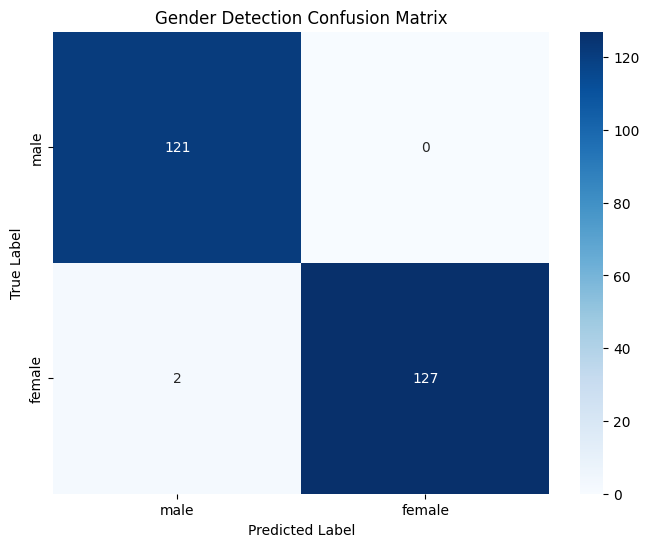



--- Evaluating Emotion Detection Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Accuracy: 0.7120
Precision: 0.7098
Recall: 0.7120

Confusion Matrix:
[[13  2  3  0  2  0  2]
 [ 0  4  2  1  4  0  0]
 [ 2  0 17  0  0  0  1]
 [ 0  1  1 17  1  1  1]
 [ 1  2  0  0 18  0  0]
 [ 1  0  0  2  0 10  0]
 [ 1  0  1  1  1  2 10]]


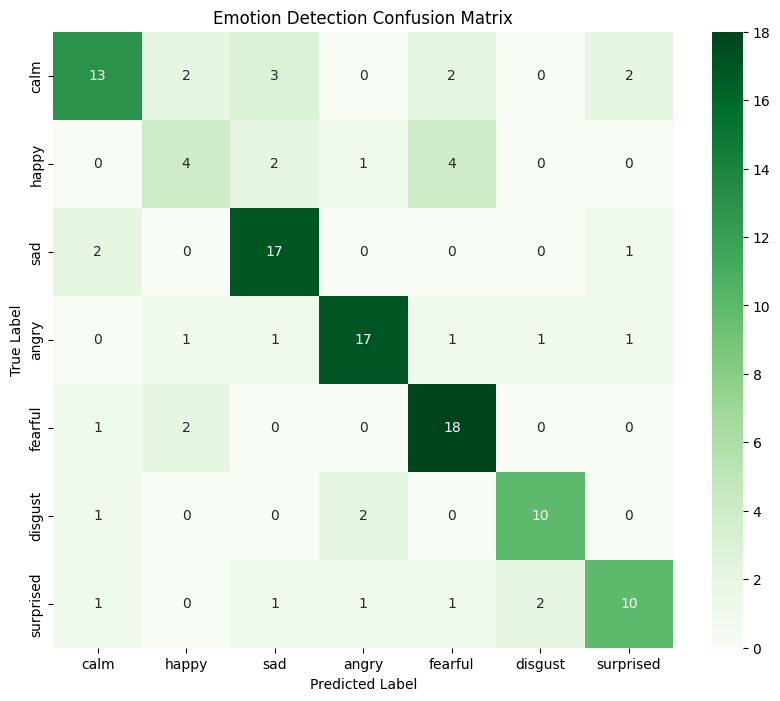

In [18]:
# Part 5: Model Evaluation and Metrics
# ==============================================================================

print("\n--- Evaluating Gender Detection Model ---")
# Make predictions on the test set
y_gender_pred = gender_model.predict(X_gender_test)
y_gender_pred_classes = np.argmax(y_gender_pred, axis=1)
y_gender_true = np.argmax(y_gender_test, axis=1)

# Calculate and print metrics
print(f"Accuracy: {accuracy_score(y_gender_true, y_gender_pred_classes):.4f}")
print(f"Precision: {precision_score(y_gender_true, y_gender_pred_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_gender_true, y_gender_pred_classes, average='weighted'):.4f}")

# Generate and display the confusion matrix
cm_gender = confusion_matrix(y_gender_true, y_gender_pred_classes)
print("\nConfusion Matrix:")
print(cm_gender)

# Plotting the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=GENDERS, yticklabels=GENDERS)
plt.title('Gender Detection Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("\n\n--- Evaluating Emotion Detection Model ---")
# Make predictions on the test set
y_emotion_pred = emotion_model.predict(X_emotion_test)
y_emotion_pred_classes = np.argmax(y_emotion_pred, axis=1)
y_emotion_true = np.argmax(y_emotion_test, axis=1)

# Calculate and print metrics
print(f"Accuracy: {accuracy_score(y_emotion_true, y_emotion_pred_classes):.4f}")
print(f"Precision: {precision_score(y_emotion_true, y_emotion_pred_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_emotion_true, y_emotion_pred_classes, average='weighted'):.4f}")

# Generate and display the confusion matrix
cm_emotion = confusion_matrix(y_emotion_true, y_emotion_pred_classes)
print("\nConfusion Matrix:")
print(cm_emotion)

# Plotting the confusion matrix for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm_emotion, annot=True, fmt='d', cmap='Greens', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Emotion Detection Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()